# **Predicting Protein Secondary Structure from Amino Acid Sequences Using a Bidirectional GRU Recurrent Neural Network**

In this project, I will use the following dataset to train a Bidirectional GRU RNN machine learning model to perform 8 state protein secondary structure prediction based on input amino acid sequences.

Dataset: https://www.kaggle.com/datasets/tamzidhasan/protein-secondary-sequence

Through doing this project, I will apply my knowledge of machine learning to concepts covered in my Molecular Genetics course.

**1. Importing Libraries and Reading in the Data**

The libraries that are used are NumPy for matrix operations and storing data, Pyplot from Matplotlib for creating model accuracy and loss plots while training, Pandas for reading in the csv file containing the dataset as a DataFrame, and Keras from TensorFlow for processing data, defining the model's architecture and hyperparameters, compiling the model, and training it.

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer

Now, I am reading in the CSV files containing the dataset as a Pandas DataFrame and displaying it. The data in the second CSV file will be used as validation data.

Here is information about the data from the dataset website.

**Dataset:**

https://www.kaggle.com/datasets/tamzidhasan/protein-secondary-sequence

**Column Abbreviations:**

serial : serial number

pdb_id : unique id of protein

seq : primary sequence

sst3 : secondary sequence H=(G,H,I); E=(B,E); C=(T,S,C)

sst8 : secondary sequence (H,B,E,G,I,T,S,C)


**Secondary Structure Labels:**

C: Loops and irregular elements (corresponding to the blank characters output by DSSP)

E: β-strand

H: α-helix

B: β-bridge

G: 3-helix

I: π-helix

T: Turn

S: Bend

Three state: [H=(G,H,I); E=(B,E); C=(T,S,C)]

In [2]:
training_data_csv = pd.read_csv('/content/PDB_31-07-2011.csv')
training_data_csv.head()

,Unnamed: 0,pdb_id,seq,sst3,sst8
0,0,12asA,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCCCCC...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSCCTT...
1,1,16vpA,SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...,CCCCCCCCCCCHHHHHHHHHHHHCCCCHHHHHHHHHHCCCCCCCCC...,CCSCCCCCCCCHHHHHHHHHHHHTCTTHHHHHHHHHHCCCCCSTTS...
2,2,1914A,MVLLESEQFLTELTRLFQKCRSSGSVFITLKKYDEGLEPAENKCLL...,CCEECHHHHHHHHHHHHHHCCCCCCEEEEEEEECCCCCCCCCEEEE...,CCEECHHHHHHHHHHHHHHTSSSCCEEEEEEEECCCCCCCCCEEEE...
3,3,1a0iA,VNIKTNPFKAVSFVESAIKKALDNAGYLIAEIKYDGVRGNICVDNT...,CCCCCCCEEEEECCHHHHHHHHHHHCCEEEEECCCCEEEEEEEECC...,CTTCCCCEEEEECCHHHHHHHHHHHSSEEEEECCCSEEEEEEEETT...
4,4,1a0pA,QDLARIEQFLDALWLEKNLAENTLNAYRRDLSMMVEWLHHRGLTLA...,CHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHCCCCCC...,CHHHHHHHHHHHHHHTTCSCHHHHHHHHHHHHHHHHHHHHTSCCTT...


**2. Data Processing**

Now that the data is stored in the DataFrame, it must be processed before if can be fed into the model for training because the model can only take in data in a specific format.

Next, I am storing the amino acid sequences and secondary structure labels for those sequences as NumPy arrays.

In [3]:
training_data_input = np.array(list(training_data_csv['seq']))
training_data_labels = np.array(list(training_data_csv['sst8']))

These numpy arrays are storing the data in the form of Strings, but the data needs to be converted into a numerical format since the model will only take numerical values as input. To do this, a Keras text vectorization layer can be used. This layer will assign integer values to each unique character in the data. Since the training data and testing data has a different amount of unique characters, two separate layers will be used. This process is done in terms of unique characters because for the amino acid sequences, each amino acid is abbreviated as one letter, and each one of the secondary structure labels is represented as a single character as well.

In [4]:
input_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=23,
    split='character'
    )

label_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=10,
    split='character'
    )

Now that the tokenizers are initialized, they must map each unique character in the two arrays to an integer and apply this mapping to convert the strings in the arrays to integer arrays. Each string will be replaced by an array of integer values, where each integer value corresponds to a character in the string.

In [5]:
input_tokenizer.adapt(training_data_input)
training_data_input = np.array(input_tokenizer(training_data_input))

In [6]:
label_tokenizer.adapt(training_data_labels)
training_data_labels = np.array(label_tokenizer(training_data_labels))

Now, I am taking 10 percent of this data to use as validation data and another 10 percent to use as testing data. The validation data is set aside to observe how the accuracy and loss of the model changes through epochs, which is one training cycle of the entire training data. This data is used rather than the training data itself because the model fits itself to the training data, so while it may perform accurately on the training data, the model can overfit and not perform well on data it has not seen yet. Overfitting is when a model fits too much to the data it was trained on and doesn't generalize to cases it hasn't seen yet. The validation data accuracy and loss can be used to see how the model accuracy and loss changes over each epoch and can be helpful in determining how many epochs to run the model for before it starts to overfit. The testing data is used to get the final trained model accuracy. This data is used rather than the training data for the same reason.

In [7]:
training_data_input, validation_data_input, testing_data_input = np.split(training_data_input, [int(0.8 * len(training_data_input)), int(0.9*len(training_data_input))])
training_data_labels, validation_data_labels, testing_data_labels = np.split(training_data_labels, [int(0.8 * len(training_data_labels)), int(0.9*len(training_data_labels))])

**3. Defining the Model's Architecture and Hyperparameters and Compiling the Model**

Now that the data is processed and ready to be fed into the model, the model's architecture and hyperparameters need to be defined. Once these are defined, the model can be compiled. A summary of the model is displayed, showing the amount of parameters for each layer and how the dimensionality of the data changes as it passes through the layers.

Details about how the model works and why its specific hyperparameters were chosen are in my paper.

In [8]:
input_sequence = Input(shape=(training_data_input[0].shape))
embedding = Embedding(23, output_dim=128)(input_sequence)
gru_layer = keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2, activation='tanh'))(embedding) #Change 16 to 32 if you have enough runtime resources

logits = TimeDistributed(Dense(10, activation='softmax'))(gru_layer)
model = Model(input_sequence, logits)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=None)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2954)]            0         
                                                                 
 embedding (Embedding)       (None, 2954, 128)         2944      
                                                                 
 bidirectional (Bidirectiona  (None, 2954, 256)        198144    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 2954, 10)         2570      
 ibuted)                                                         
                                                                 
Total params: 203,658
Trainable params: 203,658
Non-trainable params: 0
_________________________________________________________________


**4. Training the Model**

Now that the model is compiled, it can be training with the processed data. The input will be a batch of tokenized amino acid sequences, and the output will be arrays of predicted secondary structures for those sequences.

First, a custom callback function will be created to measure the accuracy of the model after each epoch using the validation data. Due to limited computational resources, a random sample of 100 sequences from the validation data will be used for this. An epoch is one training cycle of the entire training data, where the model adjusts its parameters to fit to the data to minimize the loss function, which is a measurement of how inaccurate the outputs of the model are. Then the model can be given the two arrays to train with.

The two functions below are used by the callback to convert the tokenized secondary structures from the labeled data and model's predictions to Strings for viewing purposes. This allows the predicted secondary structures and actual secondary structures of a specific amino acid to be seen side by side to compare both after the model is trained.

In [9]:
def predicted_bonds(index):
  prediction = model.predict(validation_data_input[index:index+1])
  output = ''
  for x in range(2954):
    output += label_tokenizer.get_vocabulary()[np.argmax(prediction[0][x])]
  return output

In [10]:
def labeled_bonds(index):
  integer_encoded_label = validation_data_labels[index]
  output = ''
  for x in range(2954):
    output += label_tokenizer.get_vocabulary()[integer_encoded_label[x]]
  return output

In [11]:
accuracies_after_each_epoch = np.array([])

def percent_accuracy(index):
  model_prediction = predicted_bonds(index)
  actual_bonds = labeled_bonds(index)
  correct_predictions = 0
  for x in range(len(model_prediction)):
    if(model_prediction[x] == actual_bonds[x]):
      correct_predictions += 1
  
  percent_correct = (correct_predictions / len(model_prediction)) * 100
  return percent_correct

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global accuracies_after_each_epoch
    accuracies = np.array([])
    possible_test_indexes = np.arange(len(validation_data_input))
    for x in np.random.choice(possible_test_indexes, 100, replace=False):
      accuracies = np.append(accuracies, percent_accuracy(x))
    accuracies_after_each_epoch = np.append(accuracies_after_each_epoch, np.average(accuracies))
    print(f' - accuracy: {np.average(accuracies)}')

In [12]:
history = model.fit(training_data_input, training_data_labels, batch_size=16, epochs=20, validation_data=(validation_data_input, validation_data_labels), callbacks=[CustomCallback()])

Epoch 1/20
881/881 [==============================] - 525s 587ms/step - loss: 0.1479 - val_loss: 0.1319
Epoch 2/20
881/881 [==============================] - 512s 582ms/step - loss: 0.1118 - val_loss: 0.1229
Epoch 3/20
881/881 [==============================] - 514s 583ms/step - loss: 0.1077 - val_loss: 0.1205
Epoch 4/20
881/881 [==============================] - 513s 583ms/step - loss: 0.1058 - val_loss: 0.1188
Epoch 5/20
881/881 [==============================] - 511s 580ms/step - loss: 0.1042 - val_loss: 0.1177
Epoch 6/20
881/881 [==============================] - 514s 584ms/step - loss: 0.1033 - val_loss: 0.1175
Epoch 7/20
881/881 [==============================] - 512s 581ms/step - loss: 0.1026 - val_loss: 0.1170
Epoch 8/20
881/881 [==============================] - 510s 579ms/step - loss: 0.1019 - val_loss: 0.1168
Epoch 9/20
881/881 [==============================] - 513s 582ms/step - loss: 0.1013 - val_loss: 0.1157
Epoch 10/20
881/881 [==============================] - 511s 581m

**5. Evaluating the Model**

Here is a model accuracy vs. epoch plot:

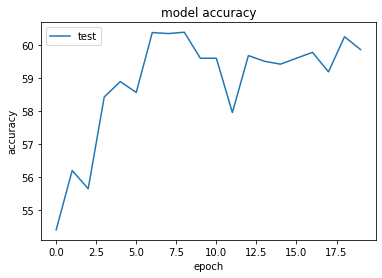

In [13]:
#Source for displaying this graph: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
##############################################################################################
plt.plot(accuracies_after_each_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.savefig("accuracy_plot_1.png")
##############################################################################################

Here is a model accuracy vs. loss plot:

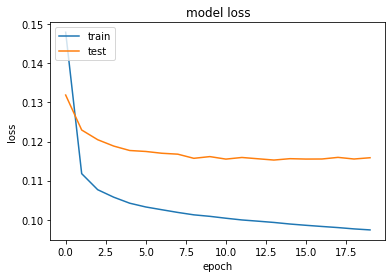

In [14]:
#Source for displaying this graph: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
##############################################################################################
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss_plot_1.png")
##############################################################################################

Now, the testing data will be used to evaluate the trained model's accuracy. A sample size of 100 from the testing data is used to calculate the model accuracy.

In [24]:
testing_accuracies = np.array([])
possible_testing_indexes = np.arange(len(testing_data_input))
for x in np.random.choice(possible_testing_indexes, 100, replace=False):
  numerical_prediction = model.predict(testing_data_input[x:x+1])
  character_prediction = ''
  for y in range(2954):
    character_prediction += label_tokenizer.get_vocabulary()[np.argmax(numerical_prediction[0][y])]

  integer_encoded_label = testing_data_labels[x]
  character_label = ''
  for y in range(2954):
    character_label += label_tokenizer.get_vocabulary()[integer_encoded_label[y]]

  correct_predictions = 0
  for y in range(len(character_prediction)):
    if(character_prediction[y] == character_label[y]):
      correct_predictions += 1
  
  percent_accuracy = correct_predictions / len(character_prediction) * 100
  testing_accuracies = np.append(testing_accuracies, percent_accuracy)

print(f'Model Accuracy: {np.average(testing_accuracies)}')

Model Accuracy: 58.704204532793895


As shown above, the model achieved approximately 59% accuracy on 8 state prediction for the testing data. For reference, current state of the art tools achieve around 72% accuracy.

**6. Using the Model**

Now that the model has been trained, it will be tested on a few sample cases.

This is the model's prediction for the secondary structure of the amino acid sequence in the first row of the DataFrame compared to its actual secondary structure:

In [25]:
predicted_bonds(0)

'cccceeeeectttceeeeeeeeecttcccccceeeeecgggccchhhhhhhhhhhhhhhheeeeeccstchechhhhhhhhhhtchtchhhhhhhhhhhhhhhhhcctcctceeeeeeechhhhhhhhhhhhtcceeeeeeeccggchhhhtcttcccceeeeeccctcghhhhhhhhhhhhhhhhttcceeeeeecsccccccchtttttccctcehchhhhhhhhhhhhhhhhhhhc'

In [26]:
labeled_bonds(0)

'ccceeeeeeeeetteeeeeeeeecttscsceeeeeeeccttbschhhhhhhhhhhhttceeeeccsssttcbccgggchhhhhhhhtchhhhhhhhhhhhhhhhtstteeeeeeeeeeethhhhhhhhhhhttcccseeeeescccccccttcttcccseeeeeeettcttschhhhhhhhhhhhhhtcceeeeeettccbtttcttggggccttbccchhhhhhhhhhhhhhhhhhcc'

This is another example for the second row:

In [27]:
predicted_bonds(1)

'ceeeeeeecechthcsteeeeeeeettcceeeehchhhhhhhhcctceeeeettteeeeeeecstchhehhhhhhhhhhhhhhhhcceeeeeeeecchhhhhhhhhhhhhtceeeeeecctccssshhhhhhhhhhhhhhhhchhhchhhhhhhhhhhhhhhhceeeectccccccchhhhhhhhhhhhhttceeeeeechhhhhhhhhhhhhhhhhhheecccceeeeeeeccgtccseeeeeetteeecttcccccccseeeeeeetttchhhhhhhhhhhhhttcceeeeeeeeccsccccghgccttseeeecttceeeeeeccsthceehhhhhhhhhhhctteeeeeeccttceeeehhhhhhhhhhchhhhhhhhhhhtccchheecthchchhhhhhhhhhhcheeecccgttthhhhhhhhhhhhhhhtcttseeeeeeccceehhtecceccttcchhhhhhhhhhhhhhhhtc'

In [28]:
labeled_bonds(1)

'cceeeeessctttcccseeeeeeettcccsttcschhhhhhttccssseeeetttteeeeeessschhhhhhhhhhhhhhhhtsscseeeeeecccccchhhhhhhhhhhhhhhttccccttcttccccscceeeeeeeeccchhhhhhhhhhhhhhhhhhhhhhhhhhhsctttschhhhhhhhhhhhhhhtceeeeechhhhhhttchhhhhhhttttttscceeeeeeeccsscsceeeeeeeeeeeeccttsccchhhhttggggghhhhhhhhhhhhhhhttcsseeeeeeeeeeeccsttcccttceeecttsceeecscttcchhhhhhhhhhhhhttccseeeeeeccchhhhhhhctteeeeeeschhhhhhhhhhhhhttceeeecccchhhhgggccsssseesscsssschhhhhhhhhhttschhhhtteeeeectttteesscbttbcseecctthhhhhhhhhhhhhtc'

In [29]:
model.save('trained_model')

INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


**Sources and Documentation Used:**

https://keras.io/api/layers/core_layers/embedding/

https://keras.io/api/layers/recurrent_layers/gru/

https://keras.io/api/layers/recurrent_layers/bidirectional/

https://keras.io/api/layers/recurrent_layers/time_distributed/

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b

https://www.tensorflow.org/guide/keras/custom_callback

**Dataset:**

https://www.kaggle.com/datasets/tamzidhasan/protein-secondary-sequence